## Caso usar o colab

In [3]:
# from google.colab import drive

# drive.mount('/content/drive')
# data_dir = "/content/drive/MyDrive/Meus códigos/data"
# print(os.listdir(data_dir))

## Caso usar localmente

In [4]:
data_dir = "./data"
print(os.listdir(data_dir))

['consumo_geladeira.csv', 'consumo_televisao.csv']


In [5]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [6]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(5)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
  print(f"Processing {file} ...")
  # Store csv file in a Pandas DataFrame
  df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])
  print(df)

  # Processing the time data into suitable input formats
  df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
  df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
  df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
  df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
  df = df.sort_values("Datetime").drop("Datetime", axis=1)
  # df = df.drop("Time", axis=1)

  # Scaling the input data
  sc = MinMaxScaler()
  label_sc = MinMaxScaler()
  data = sc.fit_transform(df.values)

  # Obtaining the scaler for the labels(usage data) so that output can be
  # re-scaled to actual value during evaluation
  label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
  label_scalers[file] = label_sc

  # Move the window
  inputs, labels = move_sliding_window(
    data,
    window_size,
    inputs_cols_indices=inputs_cols_indices,
    label_col_index=label_col_index,
  )

  # CONCAT created instances from all .csv files.
  # Split data into train/test portions and combining all data from different files into a single array
  test_portion = int(0.1 * len(inputs))
  if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
  else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
  test_x[file] = inputs[-test_portion:]
  test_y[file] = labels[-test_portion:]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing consumo_geladeira.csv ...
                  Datetime     kWh
0      2010-01-01 00:00:00  65.367
1      2010-01-01 01:00:00  66.148
2      2010-01-01 02:00:00  66.563
3      2010-01-01 03:00:00  67.453
4      2010-01-01 04:00:00  67.327
...                    ...     ...
113875 2022-12-28 19:00:00  67.263
113876 2022-12-28 20:00:00  64.365
113877 2022-12-28 21:00:00  66.663
113878 2022-12-28 22:00:00  67.096
113879 2022-12-28 23:00:00  66.192

[113880 rows x 2 columns]
(113790, 90, 5) (113790, 1)
Processing consumo_televisao.csv ...
                  Datetime     kWh
0      2010-01-01 00:00:00  21.084
1      2010-01-01 01:00:00   8.064
2      2010-01-01 02:00:00  11.803
3      2010-01-01 03:00:00   8.826
4      2010-01-01 04:00:00  15.203
...                    ...     ...
113875 2022-12-28 19:00:00  99.883
113876 2022-12-28 20:00:00  96.953
113877 2022-12-28 21:00:00  12.210
113878 2022-12-28 22:00:00   6.662
113879 2022-12-28 23:00:00  20.942

[113880 rows x 2 columns]
(113

In [7]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [8]:
print(f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}")

Train Size: (204822, 90, 5), Batch Size: 1024, # of iterations per epoch: 200


In [9]:
# release some memory
del train_x, train_y

In [10]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU is available")

CPU is available


In [11]:
class GRUNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(GRUNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.gru = nn.GRU(
      input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
    )
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.gru(x, h)
    # print(out[:, -1].shape, h.shape)
    # select hidden state of last timestamp (t=90) (1024, 256)
    out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
    # print(out.shape) # (1024, 1)
    return out, h

  def init_hidden(self, batch_size):
    # Initialze h_0 with zeros
    weight = next(self.parameters()).data
    hidden = (
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    )
    return hidden


class LSTMNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(LSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.lstm(x, h)
    out = self.fc(self.relu(out[:, -1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    # Initialze h_0, c_0 with zeros
    hidden = (
      weight.new(self.n_layers, batch_size, self.hidden_dim)
      .zero_()
      .to(device),  # h_0
      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
    )
    return hidden

In [12]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 4
print_every = 5
lr = 0.001

In [13]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

<All keys matched successfully>

In [14]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [16]:
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [17]:
def sMAPE(outputs, targets):
  sMAPE = (
    100
    / len(targets)
    * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
  )
  return sMAPE

In [18]:
def evaluate(model, test_x, test_y, label_scalers):
  model.eval()
  outputs = []
  targets = []
  start_time = time.process_time()
  # get data of test data for each state
  for file in test_x.keys():
    inputs = torch.from_numpy(np.array(test_x[file]))
    labels = torch.from_numpy(np.array(test_y[file]))

    h = model.init_hidden(inputs.shape[0])

    # predict outputs
    with torch.no_grad():
      out, h = model(inputs.to(device).float(), h)

    outputs.append(
      label_scalers[file]
      .inverse_transform(out.cpu().detach().numpy())
      .reshape(-1)
    )

    targets.append(label_scalers[file].inverse_transform(labels.numpy()).reshape(-1))

  # Merge all files
  concatenated_outputs = np.concatenate(outputs)
  concatenated_targets = np.concatenate(targets)

  print(f"Evaluation Time: {time.process_time()-start_time}")
  print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

  # list of of targets/outputs for each state
  return outputs, targets, sMAPE

In [19]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 73.4375
sMAPE: 2.258%


In [20]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 57.859375
sMAPE: 2.372%


In [21]:
len(gru_outputs)  # list of predicted output file for each state (each element has a 1d array for that state)

2

In [22]:
states_list = list(test_x.keys())

# *FEATURE 1*: Imprimindo os gráficos dos modelos de predição

1) Importando as bibliotecas para imprimir os gráficos e cálculo do erro quadrático médio

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

2) Imprimindo os gráficos em relação ao consumo da **Geladeira**:
   * Predição da GRU
   * Erro quadrático médio do modelo
   * Média do consumo real
   * Consumo real

Average consumer that freezer: 65.69775510204083


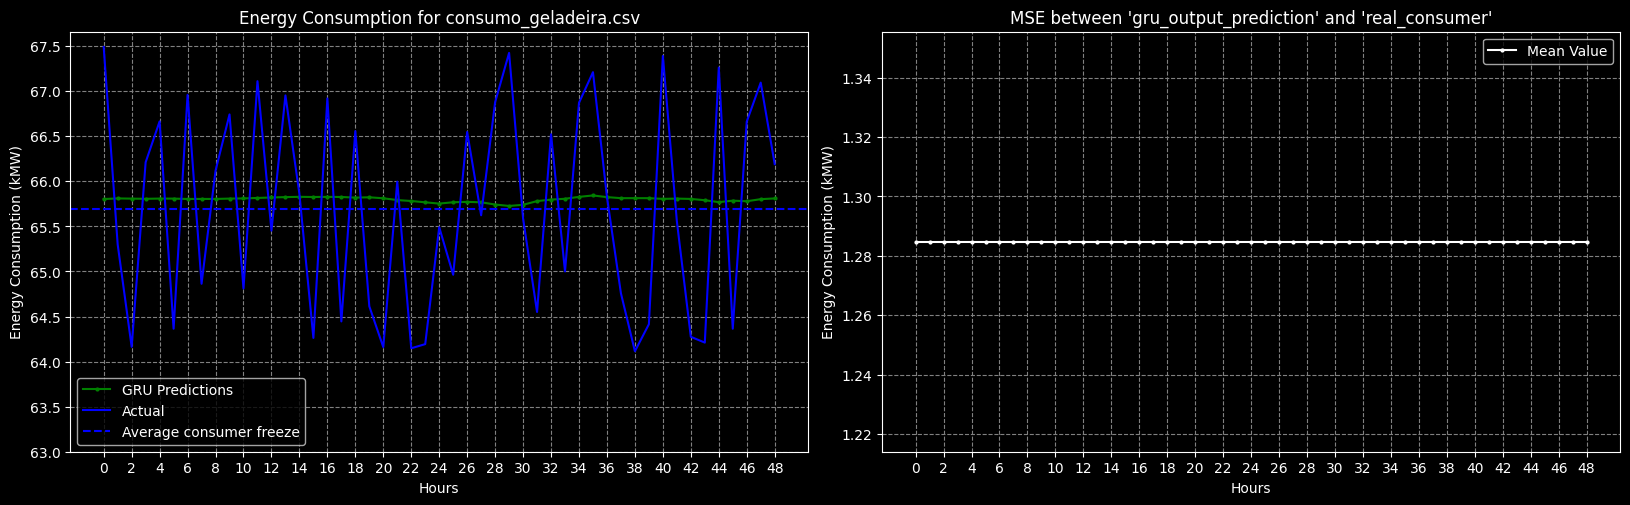

In [24]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Consumo real, acessando uma fatia dos últimos 'rangeAbscissaAxis' elementos
real_consumer = targets[0][-rangeAbscissaAxis:]
# Predição da GRU
gru_output_prediction = gru_outputs[0][-rangeAbscissaAxis:]
# Configurando as dimensões da saída
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
# Imprimindo os gráficos
plt.plot(gru_output_prediction, "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(real_consumer, color="b", label="Actual")
# Calculando e mostrando o valor da média de consumo real
day_mean = np.mean(real_consumer)
print(f"Average consumer that freezer: {day_mean}")
plt.axhline(day_mean, color="b", linestyle='dashed', label=f"Average consumer freeze")
# Unidade de medida dos eixos
plt.ylabel("Energy Consumption (kMW)")
plt.xlabel("Hours")  # Eu, Pedro Luis, criei isso pra por no artigo
plt.title(f"Energy Consumption for {states_list[0]}")
# Dimensões dos eixos
plt.yticks(np.arange(63, 68, 0.5))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.legend()
#* Erro quadrático médio
# Calcular o erro quadrático médio
mse = np.mean((real_consumer - gru_output_prediction)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(real_consumer, mse)
# Configurando as dimensões da saída
plt.subplot(2, 2, 2)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("Energy Consumption (kMW)")
plt.xlabel("Hours")
plt.title(f"MSE between 'gru_output_prediction' and 'real_consumer'")
# Dimensões dos eixos
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Ajustar espaçamento entre os subplots
plt.subplots_adjust(wspace=0.1)
# Legendando e imprimindo os gráficos
plt.legend()
plt.show()

3) Imprimindo os gráficos em relação ao consumo da **Geladeira**:
   * Predição da LSTM
   * Erro quadrático médio do modelo
   * Média do consumo real
   * Consumo real

Average consumer that freezer: 65.69775510204083


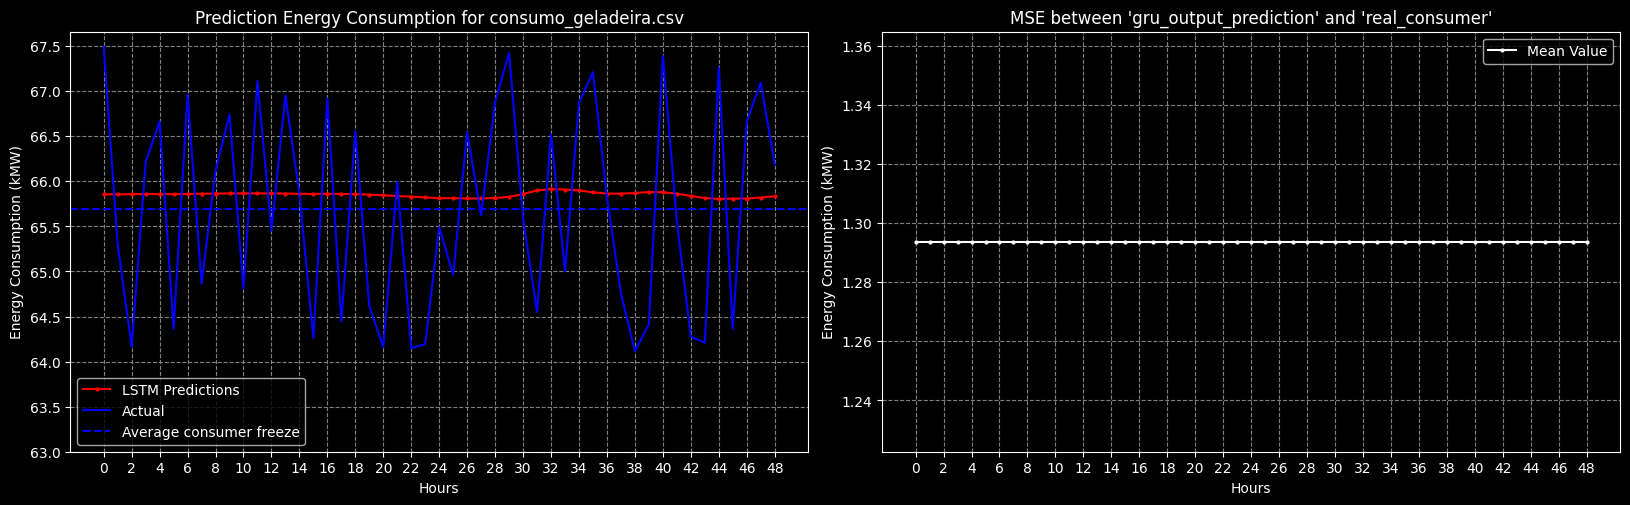

In [25]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Consumo real
real_consumer = targets[0][-rangeAbscissaAxis:]
# Predição da LSTM
lstm_output_prediction = lstm_outputs[0][-rangeAbscissaAxis:]
# TODO: Calcular a média dos valores do consumo real
# Configurando as dimensões da saída
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
# Imprimindo os gráficos
plt.plot(lstm_output_prediction, "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(real_consumer, color="b", label="Actual")
# Calculando e mostrando o valor da média de consumo real
day_mean = np.mean(real_consumer)
print(f"Average consumer that freezer: {day_mean}")
plt.axhline(day_mean, color="b", linestyle='dashed', label=f"Average consumer freeze")
# Unidade de medida dos eixos
plt.ylabel("Energy Consumption (kMW)")
plt.xlabel("Hours")  # Eu, Pedro Luis, criei isso pra por no artigo
plt.title(f"Prediction Energy Consumption for {states_list[0]}")
# Dimensões dos eixos
plt.yticks(np.arange(63, 68, 0.5))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.legend()
#* Erro quadrático médio
# Calcular o erro quadrático médio
mse = np.mean((real_consumer - lstm_output_prediction)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(real_consumer, mse)
# Configurando as dimensões da saída
plt.subplot(2, 2, 2)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("Energy Consumption (kMW)")
plt.xlabel("Hours")
plt.title(f"MSE between 'gru_output_prediction' and 'real_consumer'")
# Dimensões dos eixos
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Ajustar espaçamento entre os subplots
plt.subplots_adjust(wspace=0.1)
# Legendando e imprimindo os gráficos
plt.legend()
plt.show()

Average consumer that television: 82.2089387755102


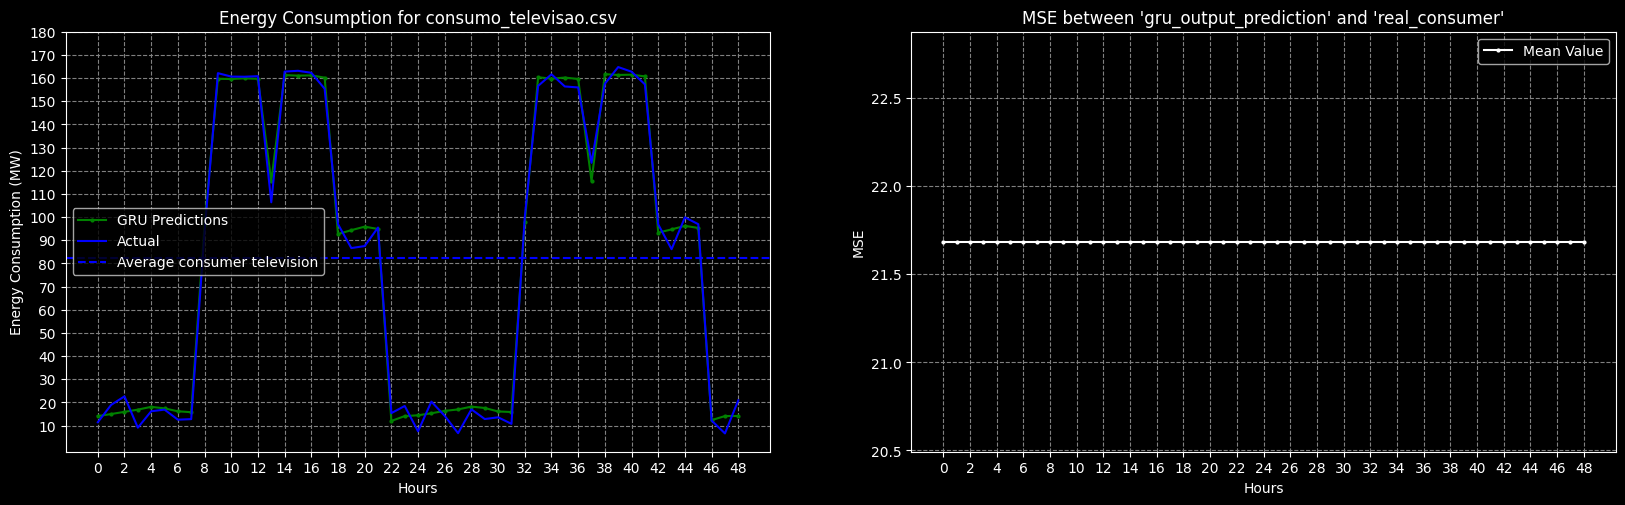

In [27]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Consumo real
real_consumer = targets[1][-rangeAbscissaAxis:]
# Predição da GRU
gru_output_prediction = gru_outputs[1][-rangeAbscissaAxis:]
# Configurando as dimensões da saída
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
# Imprimindo o gráfico
plt.plot(gru_output_prediction, "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(real_consumer, color="b", label="Actual")
# Calculando e mostrando o valor da média de consumo real
day_mean = np.mean(real_consumer)
print(f"Average consumer that television: {day_mean}")
plt.axhline(day_mean, color="b", linestyle='dashed', label=f"Average consumer television")
# Unidade de medida dos eixos
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Hours")  # Eu, Pedro Luis, criei isso pra por no artigo
plt.title(f"Energy Consumption for {states_list[1]}")
# # Dimensões dos eixos
plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.legend()
#* Erro quadrático médio
# Calcular o erro quadrático médio
mse = np.mean((real_consumer - gru_output_prediction)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(real_consumer, mse)
plt.subplot(2, 2, 2)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("MSE")
plt.xlabel("Hours")
plt.title(f"MSE between 'gru_output_prediction' and 'real_consumer'")
# Dimensões dos eixos
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Legendando e imprimindo os gráficos
plt.legend()
plt.show()

6) Imprimindo os gráficos em relação ao consumo da **Televisão**:
   * Predição da LSTM
   * Erro quadrático médio do modelo
   * Média do consumo real
   * Consumo real

Average consumer that television: 82.2089387755102


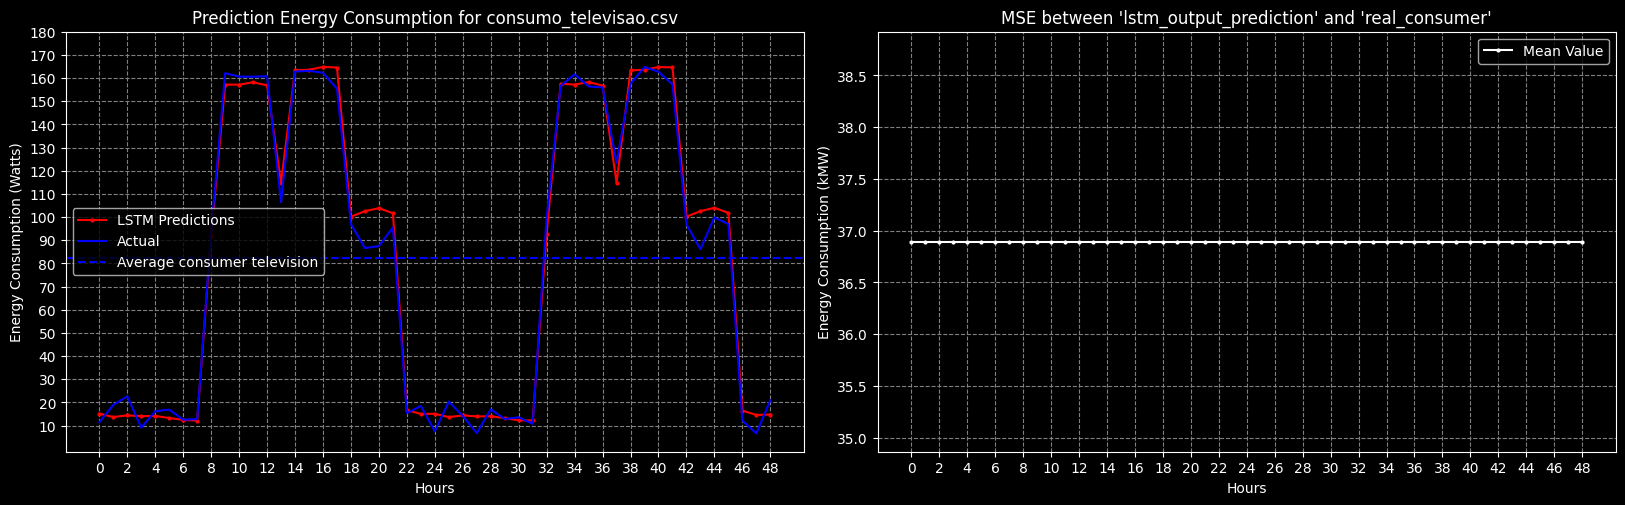

In [28]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Consumo real
real_consumer = targets[1][-rangeAbscissaAxis:]
# Predição da LSTM
lstm_output_prediction = lstm_outputs[1][-rangeAbscissaAxis:]
# Configurando as dimensões da saída
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
# Imprimindo os gráficos
plt.plot(lstm_output_prediction, "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(real_consumer, color="b", label="Actual")
# Calculando e mostrando o valor da média de consumo real
day_mean = np.mean(real_consumer)
print(f"Average consumer that television: {day_mean}")
plt.axhline(day_mean, color="b", linestyle='dashed', label=f"Average consumer television")
# Unidade de medida dos eixos
plt.ylabel("Energy Consumption (Watts)")
plt.xlabel("Hours")  # Eu, Pedro Luis, criei isso pra por no artigo
plt.title(f"Prediction Energy Consumption for {states_list[1]}")
# # Dimensões dos eixos
plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.legend()
#* Erro quadrático médio
# Calcular o erro quadrático médio
mse = np.mean((real_consumer - lstm_output_prediction)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(real_consumer, mse)
# Configurando as dimensões da saída
plt.subplot(2, 2, 2)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("Energy Consumption (kMW)")
plt.xlabel("Hours")
plt.title(f"MSE between 'lstm_output_prediction' and 'real_consumer'")
# Dimensões dos eixos
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 2))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Ajustar espaçamento entre os subplots
plt.subplots_adjust(wspace=0.1)
# Legendando e imprimindo os gráficos
plt.legend()
plt.show()

### Alguns métodos explicados
1) *`gca()`* é uma abreviação de "get current axes" (obter eixos atuais)

# FEATURE 2: Imprimindo o gráfico de 5 dias agrupados, da televisão

Day 1, average: 83.00285714285714
Day 2, average: 81.99
Day 3, average: 80.18580392156862
Day 4, average: 78.91176923076924
Day 5, average: 78.0893962264151
Day 6, average: 76.32855555555555


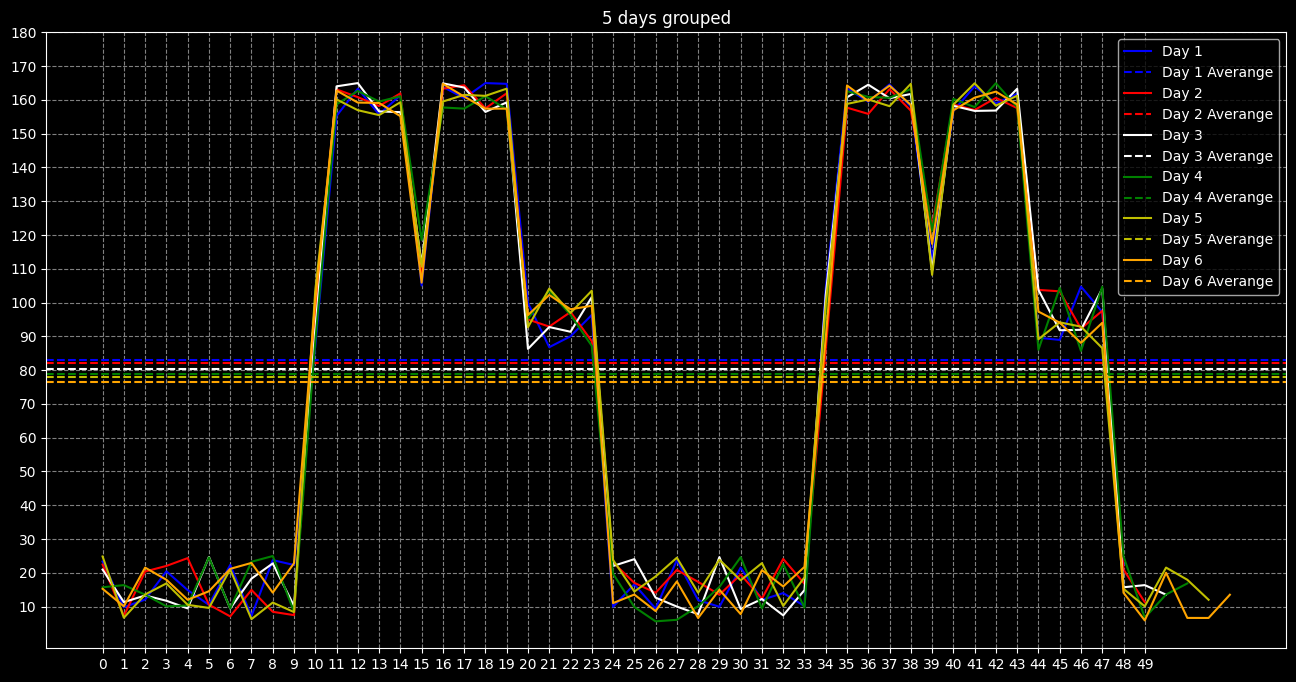

In [30]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Consumo real
# Dimensões do gráfico
plt.figure(figsize=(16, 8))

array_colors = ["b", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray", "r", "w", "g", "y", "orange", "gray"]

num_days = 6
# Imprimindo o gráfico
for i in range(0,  num_days):
  actual_range = targets[1][(rangeAbscissaAxis * i) - i : rangeAbscissaAxis * (i + 1)]
  plt.plot(actual_range, color=array_colors[i], label=f"Day {i + 1}")
  day_mean = np.mean(actual_range)
  print(f"Day {i + 1}, average: {day_mean}")
  plt.axhline(day_mean, color=array_colors[i], linestyle='dashed', label=f"Day {i + 1} Averange")

# Dimensões dos eixos
plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 1))
# Layout do gráfico
plt.title(f"5 days grouped")
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Legendando e imprimindo o gráfico
plt.legend()
plt.show()

# Calculando a média por hora

In [31]:
df = pd.read_csv("data/consumo_televisao.csv")
# Converter a coluna "Datetime" para datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Extrair a hora do dia como uma nova coluna
df['Hora'] = df['Datetime'].dt.hour
# Calcular a média para cada hora do dia
average_per_hour = df.groupby('Hora')['kWh'].mean()

# Gráfico das médias por hora

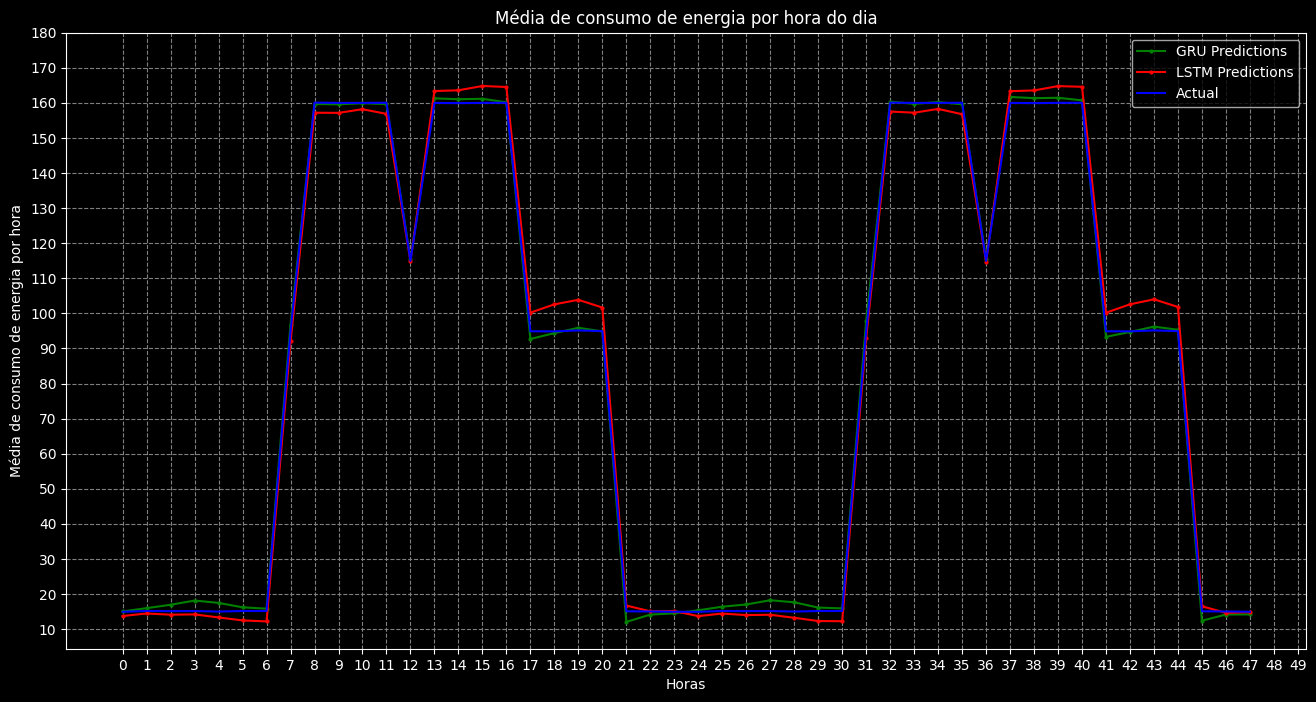

Média de consumo às 0:00:00 - 14.923465542676501
Média de consumo às 1:00:00 - 15.157303055848262
Média de consumo às 2:00:00 - 15.116745205479454
Média de consumo às 3:00:00 - 15.143419599578504
Média de consumo às 4:00:00 - 14.988572813487883
Média de consumo às 5:00:00 - 15.154987565858798
Média de consumo às 6:00:00 - 15.150895047418336
Média de consumo às 7:00:00 - 94.89810347734458
Média de consumo às 8:00:00 - 160.07174625922022
Média de consumo às 9:00:00 - 159.99672665964172
Média de consumo às 10:00:00 - 160.00044004214962
Média de consumo às 11:00:00 - 160.02930031612223
Média de consumo às 12:00:00 - 114.9562937829294
Média de consumo às 13:00:00 - 159.99066048472076
Média de consumo às 14:00:00 - 159.93067818756586
Média de consumo às 15:00:00 - 160.00899367755534
Média de consumo às 16:00:00 - 160.02457639620653
Média de consumo às 17:00:00 - 94.89275363540568
Média de consumo às 18:00:00 - 94.87258103266596
Média de consumo às 19:00:00 - 95.13819578503688
Média de consum

In [41]:
# Definindo a quantidade de horas a serem exibidas
rangeAbscissaAxis = 49
# Predição da GRU
gru_output_prediction = gru_outputs[1][1-rangeAbscissaAxis:]
# Predição da LSTM
lstm_output_prediction = lstm_outputs[1][1-rangeAbscissaAxis:]
# Gráfico da média por hora
graph_avg_per_hour = np.tile(average_per_hour, 2)

# Dimensões do gráfico
plt.figure(figsize=(16, 8))
# Imprimindo o gráfico
plt.plot(gru_output_prediction, "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_output_prediction, "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(graph_avg_per_hour, color="b", label="Actual")
plt.xlabel("Horas")
plt.ylabel("Média de consumo de energia por hora")
plt.title("Média de consumo de energia por hora do dia")
# Dimensões dos eixos
plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.legend()
plt.show()

for i in range(24):
  print(f"Média de consumo às {i}:00:00 - " + str(average_per_hour[i]))

## Calculando o MSE entre os modelos e os valores das médias

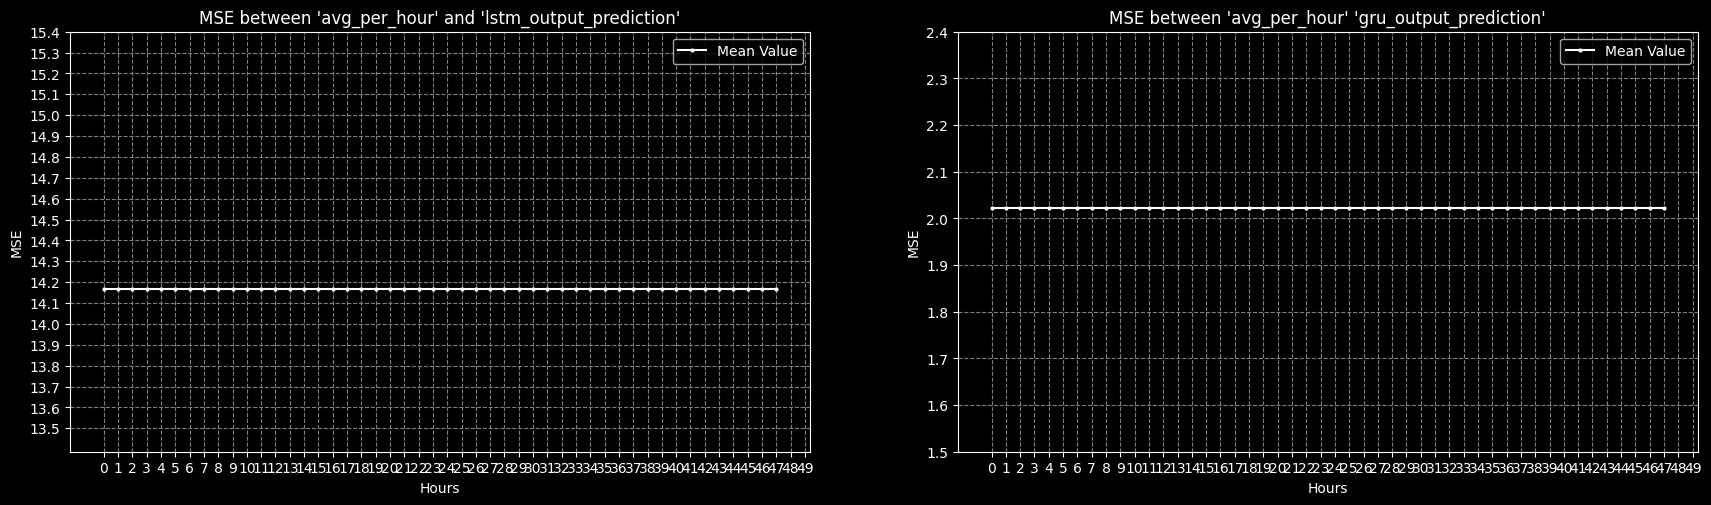

In [57]:

#! LSTM
# Configurando as dimensões da saída
plt.figure(figsize=(21, 12))
# Calcular o erro quadrático médio
mse = np.mean((lstm_output_prediction - graph_avg_per_hour)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(lstm_output_prediction, mse)
plt.subplot(2, 2, 1)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("MSE")
plt.xlabel("Hours")
plt.title(f"MSE between 'avg_per_hour' and 'lstm_output_prediction'")
# Dimensões dos eixos
# Dimensões dos eixos
plt.yticks(np.arange(13.5, 15.5, 0.1))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Legendando
plt.legend()

#! GRU
# Calcular o erro quadrático médio
mse = np.mean((gru_output_prediction - graph_avg_per_hour)**2)
# Criar um array com o valor do MSE
mean_line = np.full_like(gru_output_prediction, mse)
plt.subplot(2, 2, 2)
# Imprimindo o gráfico
plt.plot(mean_line, "-o", color="w", label="Mean Value", markersize=2)
plt.ylabel("MSE")
plt.xlabel("Hours")
plt.title(f"MSE between 'avg_per_hour' 'gru_output_prediction'")
# Dimensões dos eixos
# Dimensões dos eixos
plt.yticks(np.arange(1.5, 2.5, 0.1))
plt.xticks(np.arange(0, rangeAbscissaAxis + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# Legendando e imprimindo o gráfico
plt.legend()

plt.show()